In [1]:
import os, json
import pandas as pd
import numpy as np
from urllib.parse import urlparse, unquote

In [2]:
image_dir = ["Data/algae/algal_blooms_sweden_2022", "Data/algae/algal_blooms"]
json_path = ["Data/algae/algal_blooms_sweden_2022/_metadata_2022.json", "Data/algae/algal_blooms/_metadata_2021.json"]

imgfilter = [file for file in os.listdir("Data/algae/water") if file.lower().endswith(('.jpg', '.jpeg', '.png'))]
sin_algae = [os.path.join("Data/algae/water", filename) for filename in imgfilter]

## Check it

In [3]:
def get_unique_names(dirs):
    all_names, total_unique, total_non_unique = set(), 0, 0

    for image_dir in dirs:
        images = [i for i in os.listdir(image_dir) if not i.endswith(('json', 'csv'))]
        names = [i.split('_')[0] for i in images]

        unique_names_in_dir = set(names) - all_names
        non_unique_names_in_dir = set(names) & all_names

        total_unique += len(unique_names_in_dir)
        total_non_unique += len(non_unique_names_in_dir)
        all_names.update(names)

    return total_unique, total_non_unique

get_unique_names(image_dir)

(310, 0)

All image filename prefixes (a bunch of integers) are unique, which means we can use the strings up until the first underscore to match urls in the json. This really isn't needed for the CNN model -- but it's neat.

In [4]:
def find_matching_image_path(image_dir, prefix):
    for filename in os.listdir(image_dir):
        if filename.startswith(prefix):
            return os.path.join(image_dir, filename)
    return None

## Parse it

In [5]:
def create_df(json_path, image_dir):
    df = pd.read_json(json_path)

    for index, row in df.iterrows():
        overview_photo = unquote(os.path.basename(urlparse(row["algae_overview_photo"]).path)).split('_')[0]
        detail_photo = unquote(os.path.basename(urlparse(row["algae_detail_photo"]).path)).split('_')[0]

        if overview_photo == "" or detail_photo == "":
            df.at[index, 'algae_overview_photo'] = np.nan
            df.at[index, 'algae_detail_photo'] = np.nan

        else:
            overview_photo_path = find_matching_image_path(image_dir, overview_photo)
            detail_photo_path = find_matching_image_path(image_dir, detail_photo)

            df.at[index, 'algae_overview_photo'] = overview_photo_path if overview_photo_path else np.nan
            df.at[index, 'algae_detail_photo'] = detail_photo_path if detail_photo_path else np.nan

    df.replace("", np.nan, inplace=True)

    return df

df = pd.DataFrame()

for i, j in enumerate(json_path):
    df2 = create_df(j, image_dir[i])
    df = pd.concat([df, df2], ignore_index=True)

df.shape

(412, 9)

We use Pandas to parse the json and iterate over each rows in order to replace the urls with file paths.<br>
The colum names are self-explanatory, but we will make some modifications to them in the next steps.

## Clean it

In [6]:
old = df.shape[0]

df = df.drop('kommun', axis=1)
df = df[~df.apply(lambda row: any('test' in str(cell).lower() for cell in row), axis=1)]
df = df.dropna(subset=['algae_overview_photo', 'algae_detail_photo'], how='any')
df['comments'] = df['comments'].str.strip()
df = df[df['comments'] != 'Luktar illa'] # Invalid positional data: Not in Baltic Sea
df = df[df['report_id'] != '7c2ebee7-0992-4f2b-b180-e65089c53299'] # Invalid data: Not algea
df.drop_duplicates() # No duplicates

print(f"Dropped: {old - df.shape[0]} rows")
df.shape

Dropped: 258 rows


(154, 8)

In [7]:
df['coords'] = list(zip(df['lat'].round(5), df['long'].round(5))) # 5 decimal == 1.11 metres
center_lat, center_long = np.mean(df['lat']), np.mean(df['long'])
df = df.drop(['lat', 'long'], axis=1)

In [8]:
df = df[['report_id', 'time_spotted', 'comments', 'place', 'coords', 'algae_overview_photo', 'algae_detail_photo']]
df.columns = ['id', 'date', 'comments', 'place', 'coords', 'overview', 'detail']

Again, the *model* really won't need all this data, but hey, I do.

## View it

In [9]:
import folium
from folium.plugins import HeatMap

baltic_sea_algea_heatmap = folium.Map(location=[center_lat + 1, center_long], zoom_start=5)

heat_data = [[row['coords'][0], row['coords'][1]] for index, row in df.iterrows()]

HeatMap(heat_data).add_to(baltic_sea_algea_heatmap)

baltic_sea_algea_heatmap.save("Assets/baltic_sea_algae_heatmap.html")
display(baltic_sea_algea_heatmap)

Again, not necessary, but a fun plot!

In [10]:
df[df['place'] == 'Stockholm'].value_counts()

id                                    date        comments                                                                                                            place      coords                overview                                                                                          detail                                                                                          
614060b6-f343-45c9-9a66-35f023354f21  2021-08-05  Väldigt lokal förekomst - kort sträcka och smalt band. Ej expert så kan ej säga något om algerna (se bilder)        Stockholm  (56.56512, 16.39789)  Data/algae/algal_blooms/637637719859399773_CA6D84C5-70FD-4883-A219-726977334D5F.jpeg              Data/algae/algal_blooms/637637720177735898_7328C3EF-0195-4DA3-8CF5-08D79F4F41E2.jpeg                2
9774545b-70c0-4d15-9310-9ecae2e612e6  2021-06-19  Skiftade plats på bilderna. Tror att det är alger inte säker på att det är den giftiga sorten.. 19° I vattnet       Stockholm  (58.91032, 17.78342)  Data/alg

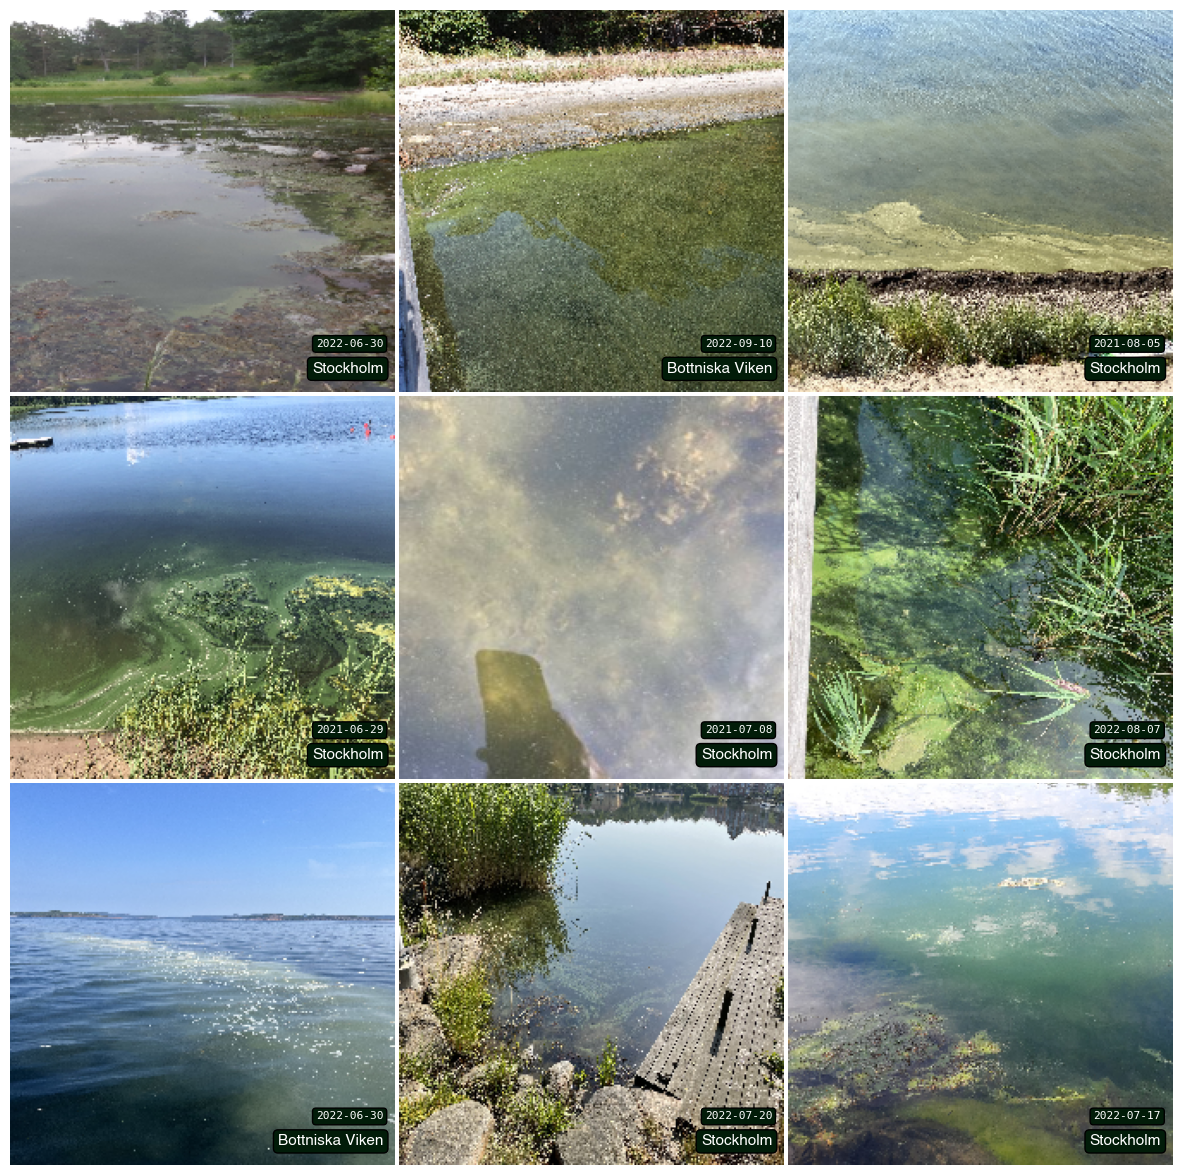

In [11]:
import matplotlib.pyplot as plt
import cv2
np.random.seed(42)

def display_images_grid(df, image_column, target_size=(224, 224), font_size=10, font_family='Helvetica'):
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    fig.subplots_adjust(wspace=0.01, hspace=0.01)

    sample_indices = np.random.choice(len(df), size=min(9, len(df)), replace=False)

    for i, ax in enumerate(axes.flatten()):
        index = sample_indices[i]
        image_path = df[image_column].iloc[index]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, target_size)
        ax.imshow(image, extent=[0, 1, 0, 1], aspect='auto')

        ax.text(0.97, 0.14, df.iloc[index]['date'], fontsize=font_size-2, fontfamily='monospace',
            color='#ffffff', ha='right', va='top',
            bbox=dict(boxstyle='round', alpha=1, facecolor='#021c09'))

        ax.text(0.97, 0.08, df.iloc[index]['place'], fontsize=font_size+1, fontfamily=font_family,
                color='#ffffff', ha='right', va='top',
                bbox=dict(boxstyle='round', alpha=1, facecolor='#021c09'))

        ax.axis('off')

    plt.show()
display_images_grid(df, 'overview')

## Size it

In [12]:
from PIL import Image

df['overview_resolution'] = None
df['detail_resolution'] = None

for index, row in df.iterrows():
    overview_path = row['overview']
    detail_path = row['detail']

    overview_image = Image.open(overview_path)
    overview_resolution = overview_image.size
    df.at[index, 'overview_resolution'] = overview_resolution

    detail_image = Image.open(detail_path)
    detail_resolution = detail_image.size
    df.at[index, 'detail_resolution'] = detail_resolution

In [13]:
np.mean(np.array(df['overview_resolution'].tolist()), axis=0), np.mean(np.array(df['detail_resolution'].tolist()), axis=0)

(array([3279.64285714, 2624.33766234]), array([3264.27922078, 2629.11688312]))

The resolutions are quite high. Which means the tensors will be quite large. We address this in the next step.

## Shrink it

In [14]:
import torch
from torchvision import transforms as T
from typing import Optional, Callable
from tensorflow.keras.preprocessing.image import img_to_array
from PIL import Image

def load_and_preprocess_images(image_paths):
    transform_function = T.Compose([T.Resize(224),
                                      T.CenterCrop(224),
                                      T.ToTensor(),
                                      ])

    images = [transform_function(Image.open(path).convert("RGB")) for path in image_paths]
    return np.array([img_to_array(img) for img in images])

2024-01-18 03:44:45.262927: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Build a model

In [15]:
import torch
import torch.nn as nn
from torchsummary import summary

class CustomModel(nn.Module):
    def __init__(self, img = [224, 224],
                 n_filters = [16, 32, 64],
                 pool_size = [2, 2, 2],
                 activates = ['relu', 'relu', 'relu'],
                 dense_units = [128], dense_activations = ['relu']):
        super(CustomModel, self).__init__()

        layers = []
        in_channels = 3 # RGB

        # Conv layers
        for filters, pooling_size, activates in zip(n_filters, pool_size, activates):
            layers.append(nn.Conv2d(in_channels, filters, kernel_size=3, padding='same'))
            layers.append(nn.ReLU(inplace=True))
            layers.append(nn.MaxPool2d(kernel_size=pooling_size))
            in_channels = filters

        conv_output_size = self._get_conv_output_size(img, in_channels, n_filters, pool_size)
        layers.append(nn.Flatten())

        # Dense (Fully connected) layers
        for units, activation in zip(dense_units, dense_activations):
            layers.append(nn.Linear(conv_output_size, units))
            layers.append(nn.ReLU(inplace=True))
            conv_output_size = units

        # Output layer
        layers.append(nn.Linear(conv_output_size, 1))
        layers.append(nn.Sigmoid())

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

    def _get_conv_output_size(self, img, in_channels, n_filters, pool_size):
        # Helper function to calculate the output size after convolutional layers
        x = torch.randn(1, in_channels, img[0], img[1])
        for i in range(len(n_filters)):
            x = nn.Conv2d(in_channels, n_filters[i], kernel_size=3, padding='same')(x)
            x = nn.ReLU(inplace=True)(x)
            x = nn.MaxPool2d(kernel_size=pool_size[i])(x)
            in_channels = n_filters[i]

        return x.view(1, -1).size(1)

# Testing with random noise
model = CustomModel()
input_tensor = torch.randn((32, 3, 224, 224))
output = model(input_tensor)
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
              ReLU-2         [-1, 16, 224, 224]               0
         MaxPool2d-3         [-1, 16, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]           4,640
              ReLU-5         [-1, 32, 112, 112]               0
         MaxPool2d-6           [-1, 32, 56, 56]               0
            Conv2d-7           [-1, 64, 56, 56]          18,496
              ReLU-8           [-1, 64, 56, 56]               0
         MaxPool2d-9           [-1, 64, 28, 28]               0
          Flatten-10                [-1, 50176]               0
           Linear-11                  [-1, 128]       6,422,656
             ReLU-12                  [-1, 128]               0
           Linear-13                    [-1, 1]             129
          Sigmoid-14                   

-1 in the output shape represents a dynamic dimension which is inferred based on the input size.

## Merge it

In [16]:
algae = df['detail'].drop_duplicates().tolist()
algae.extend(df['overview'].drop_duplicates().tolist())

X = sin_algae + algae
y = [0] * len(sin_algae) + [1] * (len(algae))

len(X) == len(y)

True

We create our dataset and labels by merging the algae and the non-algare images along with the labels (0,1)

## Split it

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

len(X_train), len(X_test)

(333, 38)

A typical split.

## Prep it

In [18]:
from torch.utils.data import DataLoader, TensorDataset

# Apply the transforms (crop, resize, #TODO Normalization)
X_train_images = load_and_preprocess_images(X_train)
X_test_images = load_and_preprocess_images(X_test)

# Convert to tensors and create DataLoader for train and test
X_train_tensor = torch.tensor(X_train_images)
y_train_tensor = torch.tensor(y_train).unsqueeze(1)  # Add a dimension for binary classification

X_test_tensor = torch.tensor(X_test_images)
y_test_tensor = torch.tensor(y_test).unsqueeze(1)

batch_size = 32

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

We perform the transformations and and populate our DataLoader with tensors. In the next step we'll start training.

## Train it

In [19]:
from torch.utils.tensorboard import SummaryWriter

model = CustomModel()
writer = SummaryWriter()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Store metrics for plotting outside TensorBoard
train_losses, test_losses, accuracies = [],[],[]

epochs = 10
for epoch in range(epochs):
    model.train()
    epoch_train_losses = []

    for inputs, labels in train_loader:
        optimizer.zero_grad()    # Zero the gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels.float())  # Get loss
        loss.backward()   # Backward pass
        optimizer.step()  # Update weights

        epoch_train_losses.append(loss.item())

    # Average training loss for the epoch
    train_loss = sum(epoch_train_losses) / len(epoch_train_losses)
    train_losses.append(train_loss)

    model.eval()
    with torch.no_grad():
        test_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels.float())
            test_loss += loss.item()
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Calculate accuracy
        accuracy = correct / total
        accuracies.append(accuracy)

        # Record the average test loss for the epoch
        test_losses.append(test_loss / len(test_loader))

        print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {train_loss:.4f}, Test Loss: {test_loss / len(test_loader):.4f}, Accuracy: {accuracy * 100:.2f}%")

writer.close()

Epoch 1/10, Training Loss: 0.6032, Test Loss: 0.7062, Accuracy: 65.79%
Epoch 2/10, Training Loss: 0.4915, Test Loss: 0.7027, Accuracy: 65.79%
Epoch 3/10, Training Loss: 0.4512, Test Loss: 0.5217, Accuracy: 71.05%
Epoch 4/10, Training Loss: 0.3725, Test Loss: 0.5000, Accuracy: 78.95%
Epoch 5/10, Training Loss: 0.3316, Test Loss: 0.4794, Accuracy: 78.95%
Epoch 6/10, Training Loss: 0.3431, Test Loss: 0.4363, Accuracy: 89.47%
Epoch 7/10, Training Loss: 0.3228, Test Loss: 0.4253, Accuracy: 86.84%
Epoch 8/10, Training Loss: 0.2495, Test Loss: 0.4657, Accuracy: 78.95%
Epoch 9/10, Training Loss: 0.3048, Test Loss: 0.3825, Accuracy: 78.95%
Epoch 10/10, Training Loss: 0.2368, Test Loss: 0.5452, Accuracy: 76.32%


Could finetune better.

## Viz it

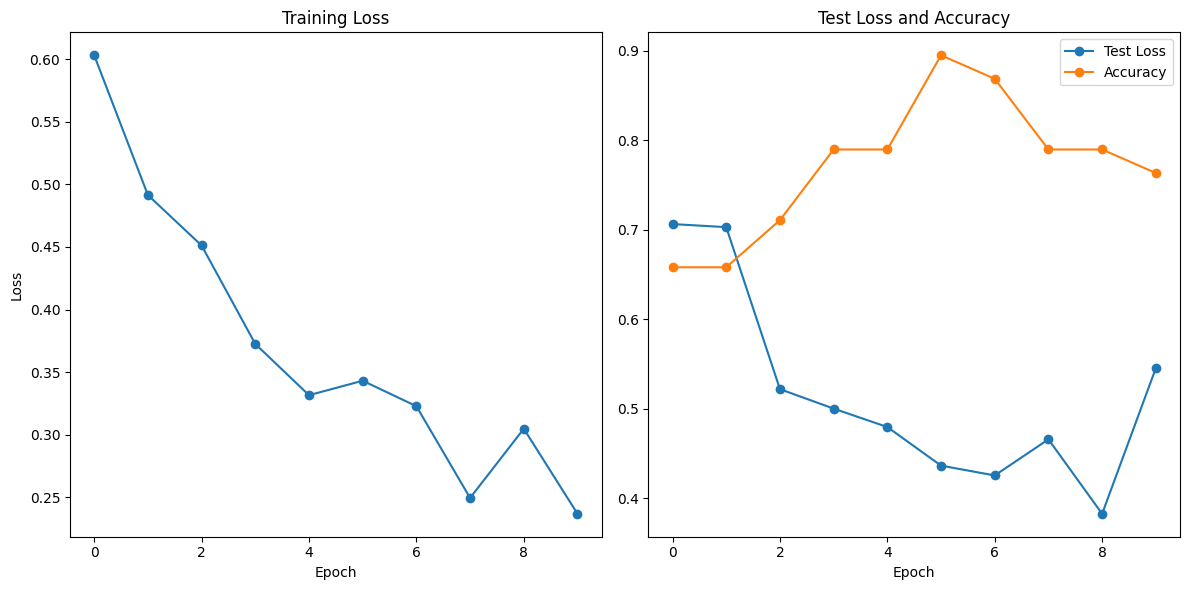

In [20]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', marker='o')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(test_losses, label='Test Loss', marker='o')
plt.plot(accuracies, label='Accuracy', marker='o')
plt.title('Test Loss and Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

## Tune it

In [21]:
#TODO

## Make inference

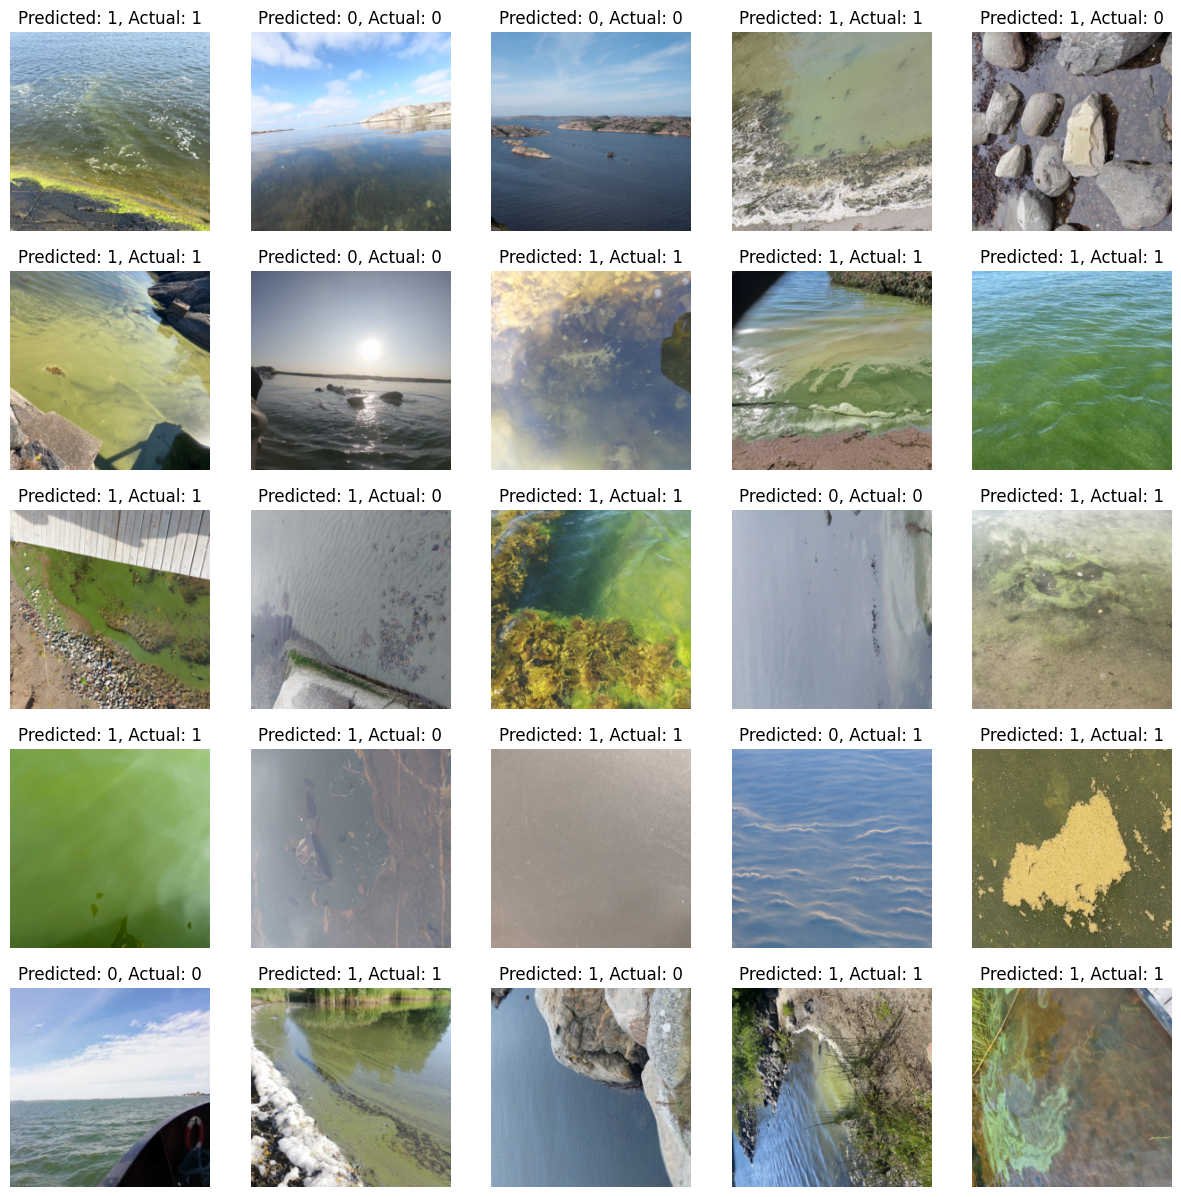

In [23]:
from torchvision.transforms.functional import to_pil_image

def visualize_predictions(model, test_loader, num_rows=5, num_cols=5):
    model.eval()

    data_iterator = iter(test_loader)
    samples, labels = next(data_iterator)
    
    with torch.no_grad():
        outputs = model(samples)
        predicted_labels = (outputs > 0.5).float()

    # Convert samples to PIL images
    sample_images = [to_pil_image(sample) for sample in samples]
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))

    for i in range(num_rows):
        for j in range(num_cols):
            idx = i * num_cols + j
            axes[i, j].imshow(sample_images[idx])
            axes[i, j].axis('off')
            axes[i, j].set_title(f'Predicted: {int(predicted_labels[idx])}, Actual: {int(labels[idx])}')

    plt.show()

visualize_predictions(model, test_loader, num_rows=5, num_cols=5)

# Technologic
## Technologic
### Technologic

old keras (not used, converted to pyTorch)

In [ ]:
# import os
# from typing import Optional, Callable
# from PIL import Image
# import numpy as np
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
# from tensorflow.keras.preprocessing.image import img_to_array
# from tensorflow.keras import optimizers
# from torchvision import transforms as T

# standard_image_transform = T.Compose([T.Resize(224),
#                                       T.CenterCrop(224),
#                                       T.ToTensor(),
#                                       T.Normalize(mean=[0.485, 0.456, 0.406],
#                                                   std=[0.229, 0.224, 0.225])
#                                       ])

# def apply_transforms(image: Image.Image, image_transform: Optional[Callable] = standard_image_transform):
#     #print(image)
#     return image_transform(image) if image_transform is not None else torch.tensor(np.array(image)).permute(2, 0, 1).float() / 255.0

# def get_model(img_size=[224, 224], num_filters=[16, 32, 64], pooling_sizes=[2, 2, 2],
#               activations=['relu', 'relu', 'relu'], dense_units=[128], dense_activations=['relu'],
#               optimizer='adam', loss='binary_crossentropy', learning_rate=0.001):
    
#     model = Sequential()

#     for filters, pooling_size, activation in zip(num_filters, pooling_sizes, activations):
#         model.add(Conv2D(filters, 3, padding='same', activation=activation, input_shape=(img_size[0], img_size[1], 3)))
#         model.add(MaxPooling2D(pool_size=pooling_size))

#     model.add(Flatten())

#     for units, activation in zip(dense_units, dense_activations):
#         model.add(Dense(units, activation=activation))

#     model.add(Dense(1, activation='sigmoid'))
#     model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

#     return model

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)


# def load_and_preprocess_images(image_paths, transform_function):
#     #print(image_paths)
    
#     images = [transform_function(Image.open(path).convert("RGB")) for path in image_paths]
#     return np.array([img_to_array(img) for img in images])


# def train_binary_classification_model(model, X_train, y_train, X_test, y_test, batch_size=32, epochs=5):
#     X_train_images = load_and_preprocess_images(X_train, apply_transforms)
#     X_test_images = load_and_preprocess_images(X_test, apply_transforms)
#     y_train, y_test = np.array(y_train), np.array(y_test)

#     X_train, X_val, y_train, y_val = train_test_split(X_train_images, y_train, test_size=0.2, random_state=42)

#     history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=batch_size, epochs=epochs)

#     test_loss, test_accuracy = model.evaluate(X_test_images, y_test)
#     print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy*100:.2f}%")

#     return history

# model = get_model()
# train_binary_classification_model(model, X_train, y_train, X_test, y_test)
